In [1]:
import os
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV,RandomizedSearchCV
from keras.preprocessing.image import img_to_array, load_img, array_to_img
from keras.applications.vgg16 import VGG16
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import string
import unidecode
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten,Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from livelossplot import PlotLossesKeras
from keras.optimizers import Adam
import tensorflow as tf
nltk.download('wordnet')
nltk.download('stopwords')
%matplotlib inline
path = os.getcwd()
pathColor= '/Users/germancarvajal/Downloads'
dataTraining = pd.read_csv(os.path.join(path, 'data', 'dataTraining.csv'), encoding='UTF-8', index_col=0)

Using TensorFlow backend.


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/germancarvajal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/germancarvajal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
Gray_Img_size=(64,40) #Size of the gray images to import 
Color_Img_size=(256,160) #Size of the color images to import with multiples of 32
words= 1000 #Number of text features to consider in the algorithm
Validation_percent = 0.2 #Fraction of data used for validation
Test_percent = 0.1 #Fraction of data used for test

In [3]:
wordnet_lemmatizer = WordNetLemmatizer()
def split_into_lemmas(text):
    text = unidecode.unidecode(text.lower())
    words = text.split()
    nopunc = [char for char in words if char not in string.punctuation]
    clean_mess = [word for word in nopunc if word not in stopwords.words('english')]
    return [wordnet_lemmatizer.lemmatize(word).encode('ascii') for word in clean_mess]

In [4]:
vect = CountVectorizer(ngram_range=(1, 2), max_features=words, analyzer=split_into_lemmas,binary=False)
X_txt = vect.fit_transform(dataTraining['plot'])
print('Text input size: ',X_txt.shape)
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(pd.Series(dataTraining['genres']).map(lambda x: eval(x)))
print('Labels input size: ',Y.shape)

('Text input size: ', (7895, 1000))
('Labels input size: ', (7895, 24))


In [5]:
Index_total=range(dataTraining.shape[0])
Index_int,Index_test=train_test_split(Index_total,test_size=Test_percent,random_state=123)
Index_train,Index_validation=train_test_split(Index_int,test_size=Validation_percent/(1-Test_percent),random_state=123)
del Index_int,Index_total
print('Training data: ',len(Index_train))
print('Validation data: ',len(Index_validation))
print('Test data: ',len(Index_test))

('Training data: ', 5526)
('Validation data: ', 1579)
('Test data: ', 790)


In [171]:
def modelGeneratorExample(iterableList,batch_size):
    while True:
        for j in range(-(-len(iterableList)/batch_size)):
            otro = np.full(batch_size,np.nan)
            x_gray = np.full((batch_size,Gray_Img_size[0],Gray_Img_size[1],1),np.nan)
            x_color = np.full((batch_size,Color_Img_size[0],Color_Img_size[1],3),np.nan)
            n=0
            for i in iterableList[j*batch_size:min(j*batch_size+batch_size,len(iterableList))]:
                img_g = load_img(os.path.join(path, 'images_resize_gray', str(dataTraining.index[i]) + '_resize_gray.jpeg'),target_size=Gray_Img_size,grayscale=True)
                x_g = img_to_array(img_g)
                x_g = x_g.reshape((1,) + x_g.shape)
                img_c = load_img(os.path.join(pathColor, 'images', str(dataTraining.index[i]) + '.jpeg'),target_size=Color_Img_size,grayscale=False)
                x_c = img_to_array(img_c)
                x_c = x_c.reshape((1,) + x_c.shape)
                x_gray[n]=x_g
                x_color[n]=x_c
                otro[n]=i
                n=n+1
            otro=otro[~np.isnan(otro)]
            x_gray=x_gray[~np.isnan(x_gray).any(axis=(1,2,3))]
            x_color=x_color[~np.isnan(x_color).any(axis=(1,2,3))]
            yield otro,X_txt[j*batch_size:min(j*batch_size+batch_size,len(iterableList))].todense(),x_gray,x_color,Y[j*batch_size:min(j*batch_size+batch_size,len(iterableList))]

In [172]:
h = modelGeneratorExample(range(5),2)

[ 4.]
(1, 1000)
(1, 64, 40, 1)
(1, 256, 160, 3)
(1, 24)
2582
[array(['accidentally', 'angeles', 'attorney', 'chief', 'convince', 'date',
       'discover', 'find', 'go', 'head', 'hide', 'house', 'however',
       'information', 'kill', 'killer', 'know', 'lawyer', 'los', 'martin',
       'meanwhile', 'michael', 'might', 'murder', 'murdered', 'office',
       'pilot', 'powerful', 'robert', 'room', 'take', 'third', 'three',
       'train', 'trying', 'witness'], 
      dtype='|S13')]
[('Action', 'Crime', 'Thriller')]


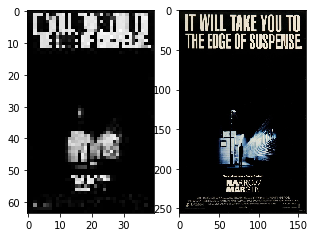

In [175]:
o,t,g,c,l=h.next()
print(o)
print(dataTraining.index[int(o[0])])
print(vect.inverse_transform(t[0]))
print(mlb.inverse_transform(l[0].reshape(1,-1)))
plt.figure(1,figsize=(5,10))
plt.subplot(121)
plt.imshow(array_to_img(g[0]))
plt.subplot(122)
plt.imshow(array_to_img(c[0]))

In [9]:
model_vgg16 = VGG16(include_top=False, weights='imagenet')
global graph
graph = tf.get_default_graph()

In [200]:
def modelGenerator(iterableList,batch_size):
    while True:
        for j in range(-(-len(iterableList)/batch_size)):
            x_gray = np.full((batch_size,Gray_Img_size[0],Gray_Img_size[1],1),np.nan)
            x_color = np.full((batch_size,Color_Img_size[0]/32,Color_Img_size[1]/32,512),np.nan)
            n=0
            for i in iterableList[j*batch_size:min(j*batch_size+batch_size,len(iterableList))]:
                img_g = load_img(os.path.join(path, 'images_resize_gray', str(dataTraining.index[i]) + '_resize_gray.jpeg'),target_size=Gray_Img_size,grayscale=True)
                x_g = img_to_array(img_g)
                x_g = x_g.reshape((1,) + x_g.shape)
                img_c = load_img(os.path.join(pathColor, 'images', str(dataTraining.index[i]) + '.jpeg'),target_size=Color_Img_size,grayscale=False)
                x_c = img_to_array(img_c)
                x_c = x_c.reshape((1,) + x_c.shape)
                with graph.as_default():
                    x_vgg = model_vgg16.predict(x_c)
                x_gray[n]=x_g
                x_color[n]=x_vgg
                n=n+1
            x_gray=x_gray[~np.isnan(x_gray).any(axis=(1,2,3))]
            x_color=x_color[~np.isnan(x_color).any(axis=(1,2,3))]
            yield [X_txt[j*batch_size:min(j*batch_size+batch_size,len(iterableList))].todense(),x_gray,x_color],Y[j*batch_size:min(j*batch_size+batch_size,len(iterableList))]

In [14]:
Text=Input(shape=(min(words,X_txt.shape[1]),),name='Text')
T1=Dense(128,activation='relu')(Text)

GrayImage = Input(shape=(Gray_Img_size[0],Gray_Img_size[1],1),name='Gray_Image')
cG1 = Conv2D(16, kernel_size=4, activation='relu')(GrayImage)
pG1 = MaxPooling2D(pool_size=(4, 4))(cG1)
flatG = Flatten()(pG1)
G1=Dense(32,activation='relu')(flatG)

VGG_out = Input(shape=(Color_Img_size[0]/32,Color_Img_size[1]/32,512),name='VGG16')
flatVGG = Flatten()(VGG_out)
C1 = Dense(128, activation='relu')(flatVGG)

merge = concatenate([T1, G1, C1])

hidden = Dense(64, activation = 'relu')(merge)
Drop = Dropout(0.5)(hidden)
output = Dense(Y.shape[1], activation='sigmoid')(Drop)

model = Model(inputs=[Text, GrayImage, VGG_out], outputs=output)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Gray_Image (InputLayer)         (None, 64, 40, 1)    0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 61, 37, 16)   272         Gray_Image[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 15, 9, 16)    0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
VGG16 (InputLayer)              (None, 8, 5, 512)    0                                            
__________________________________________________________________________________________________
Text (Inpu

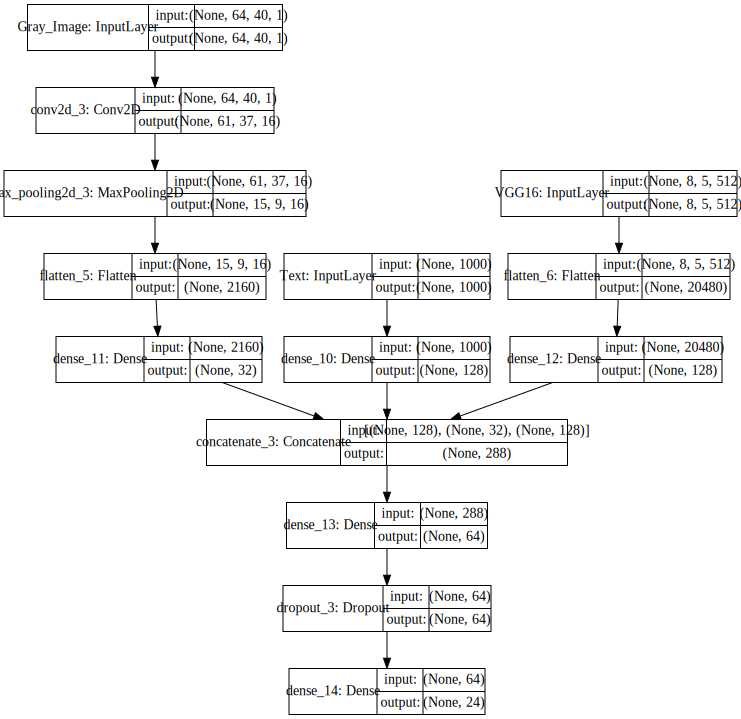

In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [205]:
adam = Adam(lr=0.01)
model.compile(optimizer = adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [203]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('Complex-{epoch:02d}-{val_acc:.2f}.hdf5',monitor='val_acc',verbose=1,save_best_only=False,save_weights_only=True,mode='auto',period=2)
earlystop = EarlyStopping(monitor='val_acc',min_delta=0.00001,patience=10,verbose=1,mode='auto')

In [201]:
TrainingEpochs=50
batch_size=50
tr=modelGenerator(Index_train,batch_size)
vl=modelGenerator(Index_validation,batch_size)

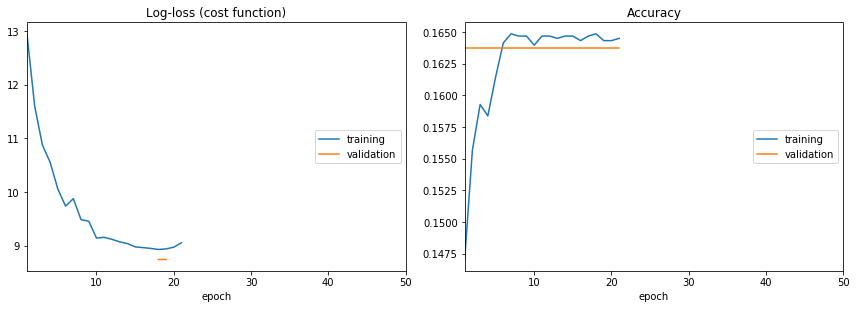

Epoch 00021: early stopping


In [19]:
np.random.seed(123)
tf.set_random_seed(123)
model.fit_generator(tr,steps_per_epoch=-(-len(Index_train)/batch_size),epochs=TrainingEpochs,verbose=1,validation_data=vl,validation_steps=-(-len(Index_validation)/batch_size),callbacks=[PlotLossesKeras(),checkpoint,earlystop])

In [188]:
ts=modelGenerator(Index_test,batch_size)
Y_pred=model.predict_generator(ts,steps=-(-len(Index_test)/batch_size),verbose=1)

16/16 [==============================] - 249s 16s/step


In [189]:
roc_auc_score(Y[Index_test],Y_pred,average='macro')

0.5